# Split the data

In [1]:
from torch_geometric.loader import DataLoader
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
import torch
from collections import Counter
import sys
sys.path.append("../src")
from reachability_model_holds_features_function import ReachabilityFeaturesGNN
from torch_geometric.data import Batch

In [2]:
# Load the Graphs
data = torch.load("../data/graph_list_holds_features.pt")

C:\Users\guanj\AppData\Local\Temp\ipykernel_24176\1844560907.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("../data/graph_list_holds_features.pt")


In [3]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Option 1: Calculate the weights

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_labels = torch.cat([g.y for g in train_data])
counts = Counter(all_labels.tolist())
total = sum(counts.values())

max_cap = 5
weights = [min(np.log(total / (counts.get(i, 1) + 1)), max_cap) for i in range(4)]
weights = torch.tensor(weights, dtype=torch.float).to(device)

In [24]:
weights

tensor([0.2439, 2.0707, 5.0000, 2.4208], device='cuda:0')

# Option 2: Use Balanced to calcualte the weights

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_labels = np.concatenate([g.y.cpu().numpy() for g in train_data])  # 转为 numpy
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [5]:
weights

tensor([  0.3190,   1.9827, 170.7643,   2.8138], device='cuda:0')

# Train the Model

In [6]:
loader = DataLoader(train_data, batch_size=8, shuffle=True)
model = ReachabilityFeaturesGNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = CrossEntropyLoss(weight=weights)

for epoch in range(50):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        out = model(batch)
        loss = loss_fn(out, batch.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

Epoch 1: Loss = 18738.1446
Epoch 2: Loss = 12212.0408
Epoch 3: Loss = 12192.0926
Epoch 4: Loss = 12203.9012
Epoch 5: Loss = 12153.1012
Epoch 6: Loss = 12164.3516
Epoch 7: Loss = 12141.0537
Epoch 8: Loss = 12119.9674
Epoch 9: Loss = 12128.9313
Epoch 10: Loss = 12128.3749
Epoch 11: Loss = 12120.5137
Epoch 12: Loss = 12109.8309
Epoch 13: Loss = 12130.4852
Epoch 14: Loss = 12103.9471
Epoch 15: Loss = 12098.5570
Epoch 16: Loss = 12099.8582
Epoch 17: Loss = 12088.1900
Epoch 18: Loss = 12101.6344
Epoch 19: Loss = 12094.1342
Epoch 20: Loss = 12085.9129
Epoch 21: Loss = 12095.3533
Epoch 22: Loss = 12100.5279
Epoch 23: Loss = 12094.3188
Epoch 24: Loss = 12077.0279
Epoch 25: Loss = 12088.4407
Epoch 26: Loss = 12086.5427
Epoch 27: Loss = 12084.4494
Epoch 28: Loss = 12082.6005
Epoch 29: Loss = 12068.2237
Epoch 30: Loss = 12049.0827
Epoch 31: Loss = 12000.4909
Epoch 32: Loss = 11931.2466
Epoch 33: Loss = 11862.9121
Epoch 34: Loss = 11861.5245
Epoch 35: Loss = 11888.8103
Epoch 36: Loss = 11864.7316
E

In [7]:
model.eval()
all_preds = []

with torch.no_grad():
    for g in train_data:
        batch = Batch.from_data_list([g]).to(device)     
        out = model(batch)                    
        pred = out.argmax(dim=1)
        all_preds.extend(pred.tolist())

print("Distribution of Predictions:", Counter(all_preds))

Distribution of Predictions: Counter({0: 2985680, 3: 2858652, 1: 1238290})


In [8]:
torch.save(model.state_dict(),"reachability_features_model2.pt")

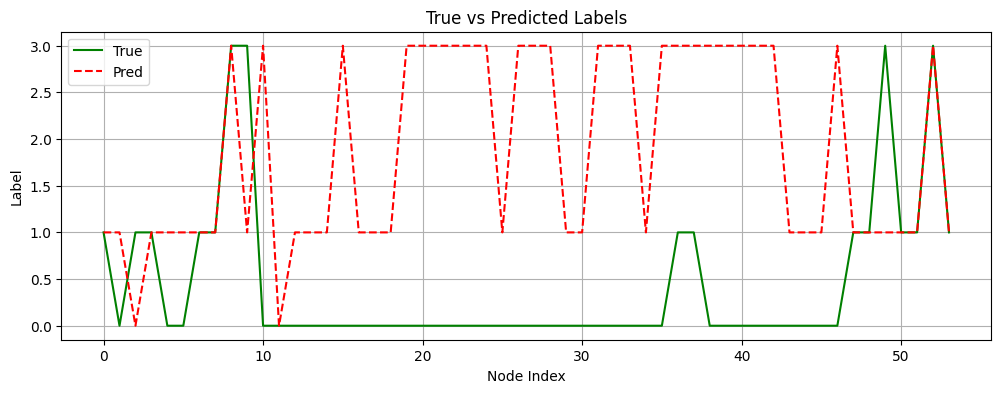

In [9]:
import matplotlib.pyplot as plt
from torch_geometric.data import Batch
graph = test_data[2450]
batch = Batch.from_data_list([graph])
batch = batch.to(device)

with torch.no_grad():
    pred_logits = model(batch)
    pred_labels = pred_logits.argmax(dim=1)

# 转 numpy
true = graph.y.cpu().numpy()
pred = pred_labels.cpu().numpy()

# 绘图
plt.figure(figsize=(12, 4))
plt.plot(true, label='True', color='green')
plt.plot(pred, label='Pred', linestyle='--', color='red')
plt.legend()
plt.title("True vs Predicted Labels")
plt.xlabel("Node Index")
plt.ylabel("Label")
plt.grid(True)
plt.show()

In [10]:
from sklearn.metrics import classification_report

all_preds, all_trues = [], []
model.eval()
with torch.no_grad():
    for g in test_data:
        batch = Batch.from_data_list([g])  
        batch = batch.to(device)
        out = model(batch)
        pred = out.argmax(dim=1).cpu().numpy()
        true = batch.y.cpu().numpy()
        all_preds.extend(pred)
        all_trues.extend(true)

print(classification_report(all_trues, all_preds, target_names=["unreachable", "hand", "foot", "both"]))

c:\Users\guanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

 unreachable       0.86      0.46      0.60   1376661
        hand       0.18      0.25      0.21    221572
        foot       0.00      0.00      0.00      2442
        both       0.12      0.54      0.19    155498

    accuracy                           0.44   1756173
   macro avg       0.29      0.31      0.25   1756173
weighted avg       0.71      0.44      0.51   1756173

